In [44]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [45]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [46]:
df = pd.read_csv("./data/Alcohol_Sales.csv", index_col = 0, parse_dates = True)

In [47]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [48]:
df.dropna(inplace=True)

<Axes: xlabel='DATE'>

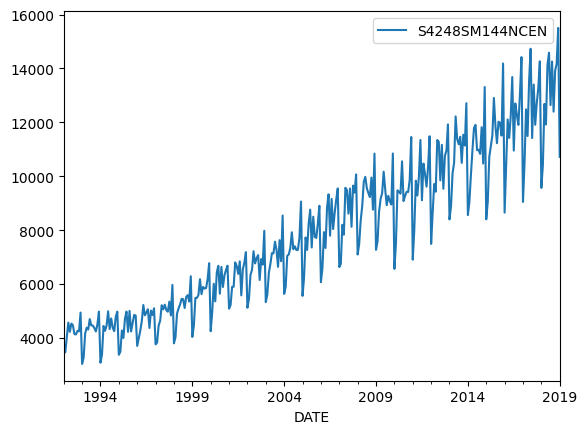

In [49]:
df.plot()

In [50]:
y = df["S4248SM144NCEN"].values.astype(np.double)

In [51]:
test_size = 12
window_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [52]:
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
trm = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = trm.fit_transform(train_set.reshape(-1, 1))

In [53]:
X = []
L = len(train_set)
for i in range(window_size-1, L - 1):
    X_slice = train_norm[i-window_size+1:i+1]
    y_slice = train_norm[i+1]
    X.append((X_slice, y_slice))

In [54]:
class TsDataSet(Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, index):
        return self.datalist[index]

In [55]:
ts_dataset = TsDataSet(X)

In [56]:
ts_loader = DataLoader(ts_dataset, batch_size=8, shuffle=False)

In [57]:
t1 = iter(ts_loader)

In [58]:
next(t1)[0].shape

torch.Size([8, 12, 1])

In [65]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, init_state=None):
        """

        :param x: (batch_size, len_seq, input_size)
        :param init_state: (batch_size, num_layers, hidden_size)
        :return:
        """
        if init_state is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        else:
            h0, c0 = init_state
        out, _ = self.lstm(x, (h0, c0))
        # 值得注意的是, nn.Linear只会对最后一个纬度进行线性变换, 但为了减少计算量,
        out = self.fc(out[:, -1, :])
        return out

In [93]:
model = LSTM()
model = model.to(device=device, dtype=torch.float32)

In [94]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [123]:
train_iter = iter(ts_loader)
losses = []
while True:
    try:
        X_train, y_train = next(train_iter)
        X_train = X_train.to(device=device, dtype=torch.float32)
        y_train = y_train.to(device=device, dtype=torch.float32)

        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    except StopIteration:
        break
print(np.mean(losses))

0.033657062032848205


In [142]:
warm_start = train_norm[-window_size:].tolist()
predicts = []
for i in range(12):
    X = torch.tensor(warm_start[-window_size:]).to(device=device, dtype=torch.float32)
    X = X.unsqueeze(0)
    with torch.no_grad():
        y_pred = model.forward(X)
    warm_start.append(y_pred.item())
    predicts.append(y_pred.item())

TypeError: not a sequence